# 🎯 Machine Learning Supervisionado
## Previsão de Valor de Venda + Probabilidade de Conversão

**Objetivos:**
1. **Regressão:** Prever o valor que um cliente vai gastar
2. **Classificação:** Prever se test drive resultará em venda

---

## 1. Setup e Importações

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib

# Configurações
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("✅ Bibliotecas importadas!")

✅ Bibliotecas importadas!


---
# 📈 PARTE 1: REGRESSÃO - PREVISÃO DE VALOR DE VENDA
---

## 2. Carregar Dados para Regressão

In [2]:
# Conectar ao banco
conn = sqlite3.connect('../vendas_carros_esportivos.db')

# Query: dados completos de vendas
query_regressao = """
SELECT 
    v.valor_venda,
    CAST((julianday(v.data_venda) - julianday(c.data_nascimento)) / 365.25 AS INTEGER) as idade_cliente,
    c.genero,
    c.renda_anual,
    ve.potencia_cv,
    ve.cilindradas,
    ve.ano_fabricacao,
    ve.categoria,
    ve.marca,
    ve.preco_base,
    v.forma_pagamento,
    v.numero_parcelas,
    v.desconto_percentual,
    vd.comissao_percentual
FROM vendas v
JOIN clientes c ON v.cliente_id = c.cliente_id
JOIN veiculos ve ON v.veiculo_id = ve.veiculo_id
JOIN vendedores vd ON v.vendedor_id = vd.vendedor_id
WHERE v.status_venda = 'Concluída'
"""

df_reg = pd.read_sql(query_regressao, conn)

print(f"✅ Dados carregados: {len(df_reg):,} vendas")
print(f"📊 Shape: {df_reg.shape}")
df_reg.head()

✅ Dados carregados: 1,393 vendas
📊 Shape: (1393, 14)


,valor_venda,idade_cliente,genero,renda_anual,potencia_cv,cilindradas,ano_fabricacao,categoria,marca,preco_base,forma_pagamento,numero_parcelas,desconto_percentual,comissao_percentual
0,1538659.37,46,Feminino,995311.89,800,6.5,2022,Gran Turismo,Ferrari,1573432.22,Financiamento,60,2.21,4.99
1,813801.15,43,Masculino,2055289.81,530,4.0,2024,Esportivo,Mercedes-AMG,861074.12,Financiamento,60,5.49,4.89
2,954343.70,45,Masculino,1502407.00,620,3.9,2022,Gran Turismo,Ferrari,988035.72,Consórcio,84,3.41,3.07
3,797010.21,31,Masculino,547788.12,530,4.0,2024,Esportivo,Mercedes-AMG,861074.12,Consórcio,60,7.44,4.76
4,578431.10,37,Masculino,1484831.52,450,2.9,2025,Esportivo,Audi,617849.93,À vista,1,6.38,4.99


## 3. Feature Engineering para Regressão

In [3]:
# Criar features adicionais
df_reg['idade_veiculo'] = 2024 - df_reg['ano_fabricacao']
df_reg['poder_compra'] = df_reg['renda_anual'] / 1000000  # Milhões
df_reg['ratio_preco_renda'] = df_reg['preco_base'] / df_reg['renda_anual']

# Encoding de variáveis categóricas
le_genero = LabelEncoder()
le_categoria = LabelEncoder()
le_marca = LabelEncoder()
le_pagamento = LabelEncoder()

df_reg['genero_encoded'] = le_genero.fit_transform(df_reg['genero'])
df_reg['categoria_encoded'] = le_categoria.fit_transform(df_reg['categoria'])
df_reg['marca_encoded'] = le_marca.fit_transform(df_reg['marca'])
df_reg['pagamento_encoded'] = le_pagamento.fit_transform(df_reg['forma_pagamento'])

print("✅ Feature engineering concluído!")
print(f"📊 Total de features: {df_reg.shape[1]}")

✅ Feature engineering concluído!
📊 Total de features: 21


In [4]:
# Selecionar features para o modelo
features_reg = ['idade_cliente', 'genero_encoded', 'renda_anual', 'potencia_cv', 
               'cilindradas', 'idade_veiculo', 'categoria_encoded', 'marca_encoded',
               'preco_base', 'pagamento_encoded', 'numero_parcelas', 
               'desconto_percentual', 'poder_compra', 'ratio_preco_renda']

X_reg = df_reg[features_reg]
y_reg = df_reg['valor_venda']

print(f"✅ Features selecionadas: {len(features_reg)}")
print(f"📊 X shape: {X_reg.shape}")
print(f"📊 y shape: {y_reg.shape}")

✅ Features selecionadas: 14
📊 X shape: (1393, 14)
📊 y shape: (1393,)


## 4. Dividir Dados (Train/Test)

In [5]:
# Split 80/20
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("✅ Dados divididos!")
print(f"📊 Treino: {X_train_reg.shape[0]:,} amostras")
print(f"📊 Teste: {X_test_reg.shape[0]:,} amostras")

✅ Dados divididos!
📊 Treino: 1,114 amostras
📊 Teste: 279 amostras


In [6]:
# Normalizar features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print("✅ Dados normalizados!")

✅ Dados normalizados!


## 5. Treinar Modelos de Regressão

In [7]:
# Dicionário de modelos
modelos_reg = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

resultados_reg = {}

print("🤖 Treinando modelos...\n")

for nome, modelo in modelos_reg.items():
    print(f"Treinando {nome}...")
    
    # Treinar
    modelo.fit(X_train_reg_scaled, y_train_reg)
    
    # Prever
    y_pred_train = modelo.predict(X_train_reg_scaled)
    y_pred_test = modelo.predict(X_test_reg_scaled)
    
    # Métricas
    mae_test = mean_absolute_error(y_test_reg, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test_reg, y_pred_test))
    r2_train = r2_score(y_train_reg, y_pred_train)
    r2_test = r2_score(y_test_reg, y_pred_test)
    
    resultados_reg[nome] = {
        'modelo': modelo,
        'MAE': mae_test,
        'RMSE': rmse_test,
        'R² Train': r2_train,
        'R² Test': r2_test
    }
    
    print(f"   R² Test: {r2_test:.4f}")
    print(f"   MAE: R$ {mae_test:,.2f}")
    print(f"   RMSE: R$ {rmse_test:,.2f}\n")

print("✅ Treinamento concluído!")

🤖 Treinando modelos...

Treinando Linear Regression...
   R² Test: 0.9984
   MAE: R$ 8,521.80
   RMSE: R$ 12,748.03

Treinando Ridge...
   R² Test: 0.9983
   MAE: R$ 8,593.86
   RMSE: R$ 12,790.63

Treinando Lasso...
   R² Test: 0.9984
   MAE: R$ 8,521.75
   RMSE: R$ 12,748.05

Treinando Random Forest...
   R² Test: 0.9997
   MAE: R$ 3,710.94
   RMSE: R$ 5,629.43

Treinando Gradient Boosting...
   R² Test: 0.9997
   MAE: R$ 3,788.58
   RMSE: R$ 5,463.29

✅ Treinamento concluído!


## 6. Comparar Modelos de Regressão

In [8]:
# Tabela comparativa
df_resultados_reg = pd.DataFrame(resultados_reg).T.drop('modelo', axis=1)
df_resultados_reg = df_resultados_reg.sort_values('R² Test', ascending=False)

print("📊 COMPARAÇÃO DOS MODELOS DE REGRESSÃO:")
print(df_resultados_reg)

📊 COMPARAÇÃO DOS MODELOS DE REGRESSÃO:
                           MAE          RMSE  R² Train   R² Test
Gradient Boosting  3788.578854   5463.292092  0.999888  0.999698
Random Forest      3710.941796   5629.428444  0.999936  0.999679
Linear Regression  8521.797527  12748.033846  0.998302  0.998355
Lasso              8521.750081  12748.052809  0.998302  0.998355
Ridge              8593.856629  12790.625495  0.998299  0.998344


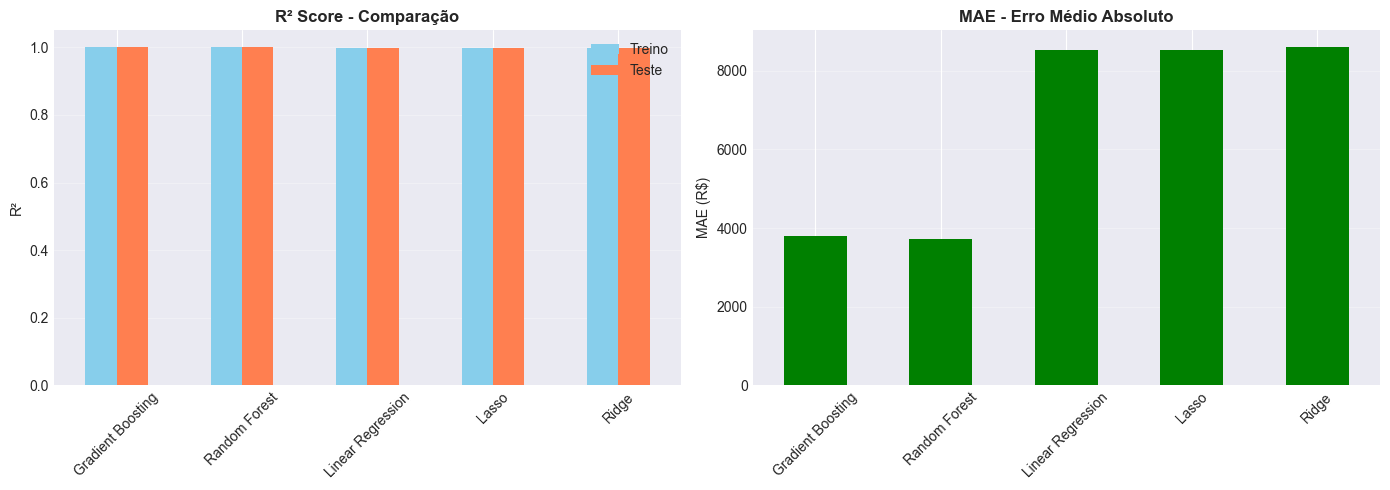


🏆 Melhor modelo: Gradient Boosting
   R² Test: 0.9997


In [9]:
# Visualizar comparação
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Score
df_resultados_reg[['R² Train', 'R² Test']].plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'])
axes[0].set_title('R² Score - Comparação', fontweight='bold')
axes[0].set_ylabel('R²')
axes[0].set_xlabel('')
axes[0].legend(['Treino', 'Teste'])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# MAE
df_resultados_reg['MAE'].plot(kind='bar', ax=axes[1], color='green')
axes[1].set_title('MAE - Erro Médio Absoluto', fontweight='bold')
axes[1].set_ylabel('MAE (R$)')
axes[1].set_xlabel('')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Melhor modelo
melhor_modelo_reg = df_resultados_reg['R² Test'].idxmax()
print(f"\n🏆 Melhor modelo: {melhor_modelo_reg}")
print(f"   R² Test: {df_resultados_reg.loc[melhor_modelo_reg, 'R² Test']:.4f}")

## 7. Análise do Melhor Modelo (Regressão)

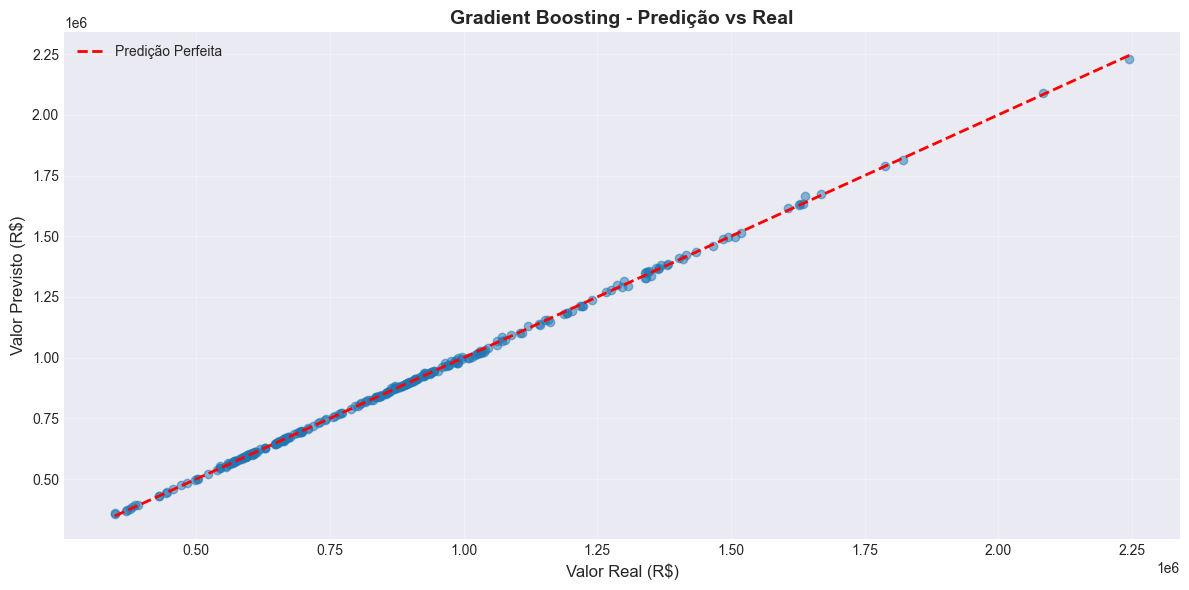

In [10]:
# Pegar melhor modelo
modelo_final_reg = resultados_reg[melhor_modelo_reg]['modelo']
y_pred_final = modelo_final_reg.predict(X_test_reg_scaled)

# Visualizar predições vs real
plt.figure(figsize=(12, 6))
plt.scatter(y_test_reg, y_pred_final, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
        [y_test_reg.min(), y_test_reg.max()], 
        'r--', lw=2, label='Predição Perfeita')
plt.xlabel('Valor Real (R$)', fontsize=12)
plt.ylabel('Valor Previsto (R$)', fontsize=12)
plt.title(f'{melhor_modelo_reg} - Predição vs Real', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

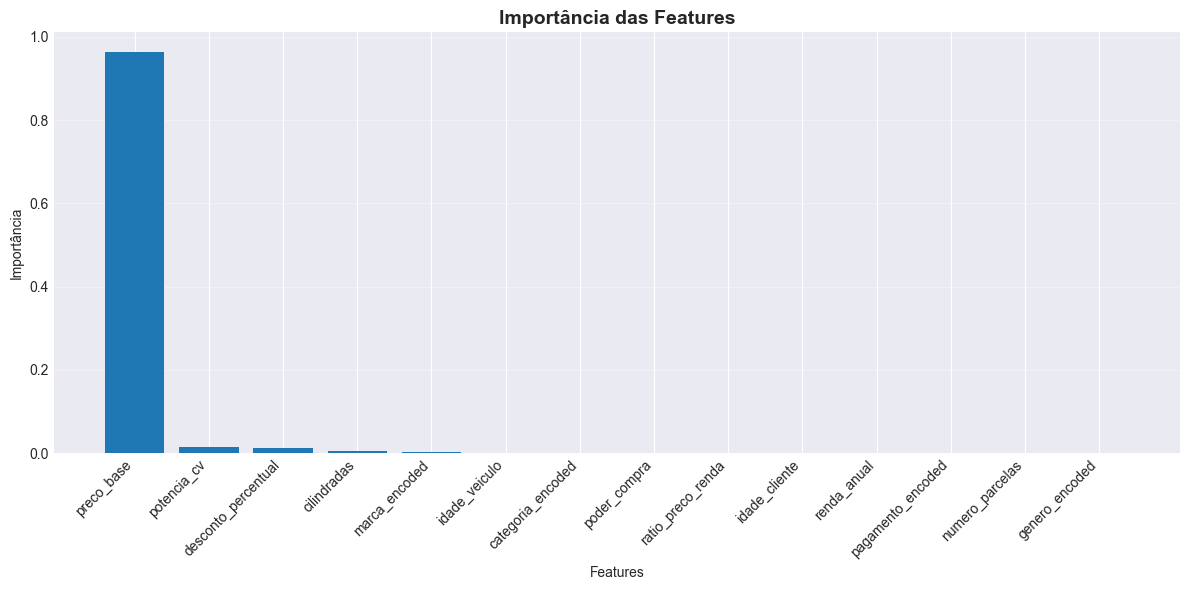


📊 Top 5 Features Mais Importantes:
   preco_base: 0.9626
   potencia_cv: 0.0157
   desconto_percentual: 0.0128
   cilindradas: 0.0061
   marca_encoded: 0.0019


In [11]:
# Feature importance (se Random Forest ou Gradient Boosting)
if melhor_modelo_reg in ['Random Forest', 'Gradient Boosting']:
    importances = modelo_final_reg.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [features_reg[i] for i in indices], rotation=45, ha='right')
    plt.title('Importância das Features', fontsize=14, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Importância')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Top 5 Features Mais Importantes:")
    for i in range(min(5, len(indices))):
        print(f"   {features_reg[indices[i]]}: {importances[indices[i]]:.4f}")

## 8. Salvar Modelo de Regressão

In [12]:
# Criar diretório models se não existir
import os
os.makedirs('../Modelos', exist_ok=True)

# Salvar modelo e scaler
joblib.dump(modelo_final_reg, '../Modelos/modelo_regressao.pkl')
joblib.dump(scaler_reg, '../Modelos/scaler_regressao.pkl')
joblib.dump(features_reg, '../Modelos/features_regressao.pkl')

print("✅ Modelo de regressão salvo!")
print("   📁 Modelos/modelo_regressao.pkl")
print("   📁 Modelos/scaler_regressao.pkl")
print("   📁 Modelos/features_regressao.pkl")

✅ Modelo de regressão salvo!
   📁 Modelos/modelo_regressao.pkl
   📁 Modelos/scaler_regressao.pkl
   📁 Modelos/features_regressao.pkl


---
# 🎯 PARTE 2: CLASSIFICAÇÃO - PROBABILIDADE DE CONVERSÃO
---

## 9. Carregar Dados para Classificação

In [13]:
# Query: dados de test drives
query_classificacao = """
SELECT 
    td.resultou_venda,
    CAST((julianday(td.data_test_drive) - julianday(c.data_nascimento)) / 365.25 AS INTEGER) as idade_cliente,
    c.genero,
    c.renda_anual,
    ve.potencia_cv,
    ve.cilindradas,
    ve.ano_fabricacao,
    ve.categoria,
    ve.marca,
    ve.preco_base,
    td.avaliacao,
    CAST(strftime('%w', td.data_test_drive) AS INTEGER) as dia_semana,
    CAST(strftime('%H', td.data_test_drive) AS INTEGER) as hora
FROM test_drives td
JOIN clientes c ON td.cliente_id = c.cliente_id
JOIN veiculos ve ON td.veiculo_id = ve.veiculo_id
"""

df_clf = pd.read_sql(query_classificacao, conn)
conn.close()

print(f"✅ Dados carregados: {len(df_clf):,} test drives")
print(f"📊 Shape: {df_clf.shape}")
print(f"\n📊 Distribuição da variável alvo:")
print(df_clf['resultou_venda'].value_counts())
print(f"\n📈 Taxa de conversão: {df_clf['resultou_venda'].mean():.2%}")

✅ Dados carregados: 2,960 test drives
📊 Shape: (2960, 13)

📊 Distribuição da variável alvo:
resultou_venda
0    1987
1     973
Name: count, dtype: int64

📈 Taxa de conversão: 32.87%


## 10. Feature Engineering para Classificação

In [14]:
# Criar features
df_clf['idade_veiculo'] = 2024 - df_clf['ano_fabricacao']
df_clf['poder_compra'] = df_clf['renda_anual'] / 1000000
df_clf['ratio_preco_renda'] = df_clf['preco_base'] / df_clf['renda_anual']
df_clf['final_semana'] = (df_clf['dia_semana'] >= 5).astype(int)
df_clf['horario_comercial'] = ((df_clf['hora'] >= 9) & (df_clf['hora'] <= 18)).astype(int)

# Encoding
le_genero_clf = LabelEncoder()
le_categoria_clf = LabelEncoder()
le_marca_clf = LabelEncoder()

df_clf['genero_encoded'] = le_genero_clf.fit_transform(df_clf['genero'])
df_clf['categoria_encoded'] = le_categoria_clf.fit_transform(df_clf['categoria'])
df_clf['marca_encoded'] = le_marca_clf.fit_transform(df_clf['marca'])

print("✅ Feature engineering concluído!")

✅ Feature engineering concluído!


In [15]:
# Selecionar features
features_clf = ['idade_cliente', 'genero_encoded', 'renda_anual', 'potencia_cv',
               'cilindradas', 'idade_veiculo', 'categoria_encoded', 'marca_encoded',
               'preco_base', 'avaliacao', 'dia_semana', 'hora', 'poder_compra',
               'ratio_preco_renda', 'final_semana', 'horario_comercial']

X_clf = df_clf[features_clf]
y_clf = df_clf['resultou_venda']

print(f"✅ Features selecionadas: {len(features_clf)}")
print(f"📊 X shape: {X_clf.shape}")
print(f"📊 y shape: {y_clf.shape}")

✅ Features selecionadas: 16
📊 X shape: (2960, 16)
📊 y shape: (2960,)


## 11. Dividir Dados (Train/Test)

In [16]:
# Split 80/20 com stratify (manter proporção de classes)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("✅ Dados divididos!")
print(f"📊 Treino: {X_train_clf.shape[0]:,} amostras")
print(f"📊 Teste: {X_test_clf.shape[0]:,} amostras")
print(f"\n📊 Distribuição Treino:")
print(y_train_clf.value_counts())
print(f"\n📊 Distribuição Teste:")
print(y_test_clf.value_counts())

✅ Dados divididos!
📊 Treino: 2,368 amostras
📊 Teste: 592 amostras

📊 Distribuição Treino:
resultou_venda
0    1590
1     778
Name: count, dtype: int64

📊 Distribuição Teste:
resultou_venda
0    397
1    195
Name: count, dtype: int64


In [17]:
# Normalizar
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print("✅ Dados normalizados!")

✅ Dados normalizados!


## 12. Treinar Modelos de Classificação

In [18]:
from sklearn.linear_model import LogisticRegression

# Dicionário de modelos
modelos_clf = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

resultados_clf = {}

print("🤖 Treinando modelos de classificação...\n")

for nome, modelo in modelos_clf.items():
    print(f"Treinando {nome}...")
    
    # Treinar
    modelo.fit(X_train_clf_scaled, y_train_clf)
    
    # Prever
    y_pred = modelo.predict(X_test_clf_scaled)
    y_pred_proba = modelo.predict_proba(X_test_clf_scaled)[:, 1]
    
    # Métricas
    accuracy = accuracy_score(y_test_clf, y_pred)
    precision = precision_score(y_test_clf, y_pred)
    recall = recall_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred)
    roc_auc = roc_auc_score(y_test_clf, y_pred_proba)
    
    resultados_clf[nome] = {
        'modelo': modelo,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}\n")

print("✅ Treinamento concluído!")

🤖 Treinando modelos de classificação...

Treinando Logistic Regression...
   Accuracy: 0.7010
   F1-Score: 0.4840
   ROC-AUC: 0.8011

Treinando Random Forest...
   Accuracy: 0.7314
   F1-Score: 0.5827
   ROC-AUC: 0.8326

Treinando Gradient Boosting...
   Accuracy: 0.7314
   F1-Score: 0.5934
   ROC-AUC: 0.8302

✅ Treinamento concluído!


## 13. Comparar Modelos de Classificação

In [19]:
# Tabela comparativa
df_resultados_clf = pd.DataFrame(resultados_clf).T.drop('modelo', axis=1)
df_resultados_clf = df_resultados_clf.sort_values('ROC-AUC', ascending=False)

print("📊 COMPARAÇÃO DOS MODELOS DE CLASSIFICAÇÃO:")
print(df_resultados_clf)

📊 COMPARAÇÃO DOS MODELOS DE CLASSIFICAÇÃO:
                     Accuracy Precision    Recall  F1-Score   ROC-AUC
Random Forest        0.731419  0.596774  0.569231  0.582677  0.832558
Gradient Boosting    0.731419  0.591837  0.594872   0.59335  0.830162
Logistic Regression  0.701014  0.560811  0.425641  0.483965  0.801072


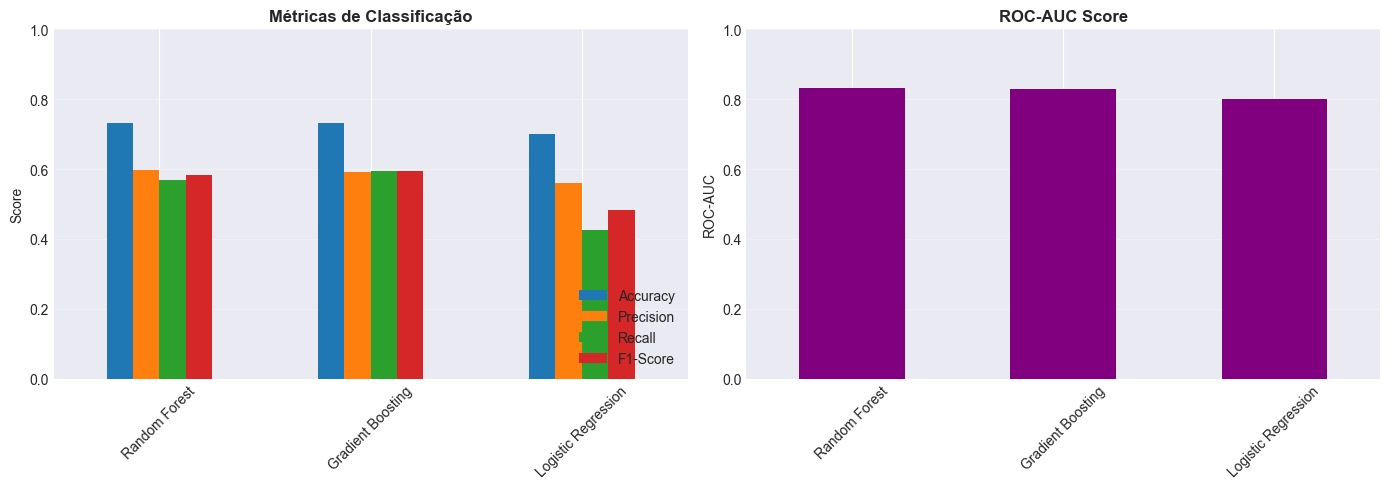


🏆 Melhor modelo: Random Forest
   ROC-AUC: 0.8326


In [20]:
# Visualizar comparação
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Todas as métricas
df_resultados_clf[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Métricas de Classificação', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim([0, 1])

# ROC-AUC
df_resultados_clf['ROC-AUC'].plot(kind='bar', ax=axes[1], color='purple')
axes[1].set_title('ROC-AUC Score', fontweight='bold')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_xlabel('')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Melhor modelo
melhor_modelo_clf = df_resultados_clf['ROC-AUC'].idxmax()
print(f"\n🏆 Melhor modelo: {melhor_modelo_clf}")
print(f"   ROC-AUC: {df_resultados_clf.loc[melhor_modelo_clf, 'ROC-AUC']:.4f}")

## 14. Análise do Melhor Modelo (Classificação)

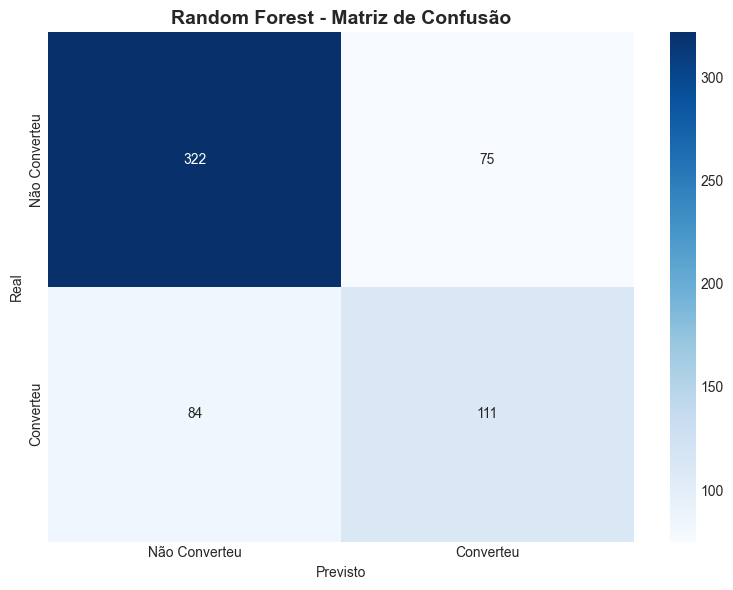


📊 Classification Report:
               precision    recall  f1-score   support

Não Converteu       0.79      0.81      0.80       397
    Converteu       0.60      0.57      0.58       195

     accuracy                           0.73       592
    macro avg       0.69      0.69      0.69       592
 weighted avg       0.73      0.73      0.73       592



In [21]:
# Pegar melhor modelo
modelo_final_clf = resultados_clf[melhor_modelo_clf]['modelo']
y_pred_clf = modelo_final_clf.predict(X_test_clf_scaled)
y_pred_proba_clf = modelo_final_clf.predict_proba(X_test_clf_scaled)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Não Converteu', 'Converteu'],
           yticklabels=['Não Converteu', 'Converteu'])
plt.title(f'{melhor_modelo_clf} - Matriz de Confusão', fontsize=14, fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.tight_layout()
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test_clf, y_pred_clf, 
                          target_names=['Não Converteu', 'Converteu']))

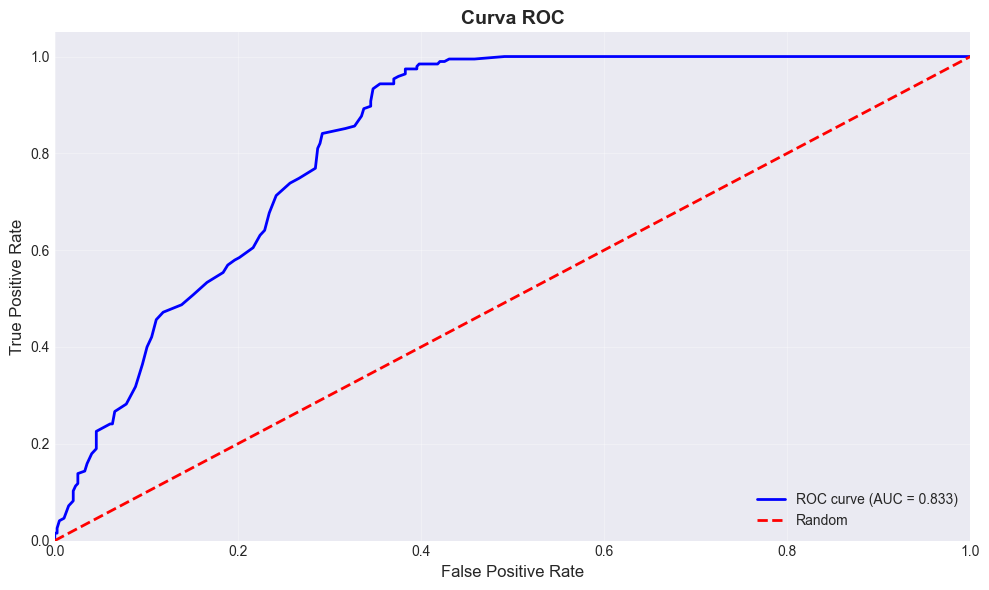

In [22]:
# Curva ROC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba_clf)
roc_auc = roc_auc_score(y_test_clf, y_pred_proba_clf)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curva ROC', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

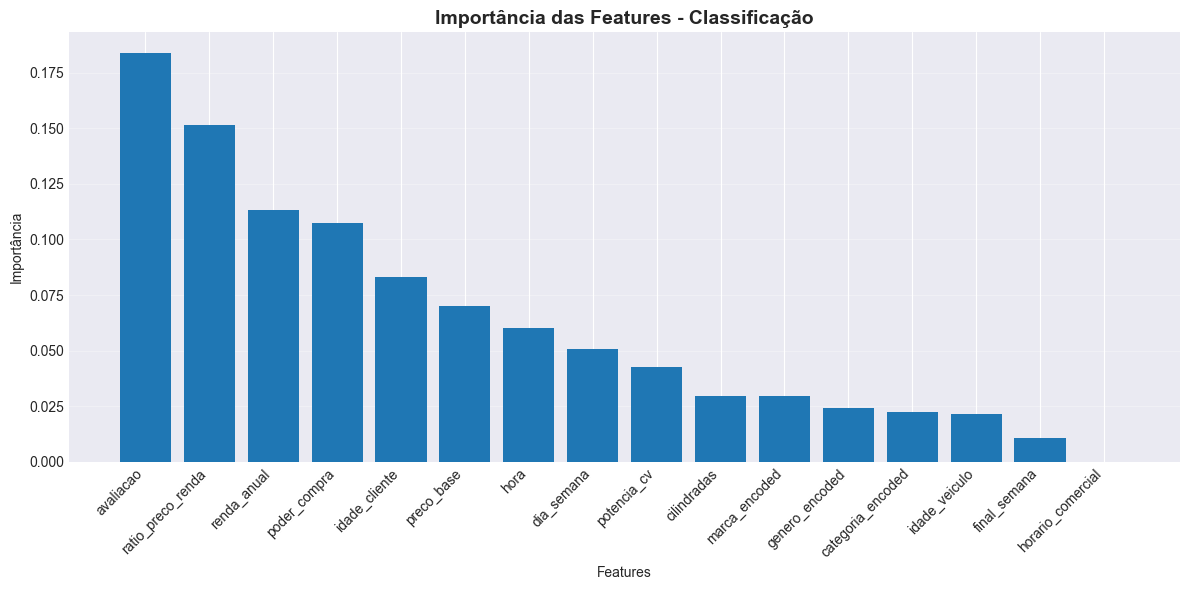


📊 Top 5 Features Mais Importantes:
   avaliacao: 0.1839
   ratio_preco_renda: 0.1515
   renda_anual: 0.1132
   poder_compra: 0.1073
   idade_cliente: 0.0830


In [23]:
# Feature importance (se RF ou GB)
if melhor_modelo_clf in ['Random Forest', 'Gradient Boosting']:
    importances_clf = modelo_final_clf.feature_importances_
    indices_clf = np.argsort(importances_clf)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importances_clf)), importances_clf[indices_clf])
    plt.xticks(range(len(importances_clf)), [features_clf[i] for i in indices_clf], 
              rotation=45, ha='right')
    plt.title('Importância das Features - Classificação', fontsize=14, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel('Importância')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Top 5 Features Mais Importantes:")
    for i in range(min(5, len(indices_clf))):
        print(f"   {features_clf[indices_clf[i]]}: {importances_clf[indices_clf[i]]:.4f}")

## 15. Salvar Modelo de Classificação

In [24]:
# Salvar modelo e scaler
joblib.dump(modelo_final_clf, '../Modelos/modelo_classificacao.pkl')
joblib.dump(scaler_clf, '../Modelos/scaler_classificacao.pkl')
joblib.dump(features_clf, '../Modelos/features_classificacao.pkl')

print("✅ Modelo de classificação salvo!")
print("   📁 models/modelo_classificacao.pkl")
print("   📁 models/scaler_classificacao.pkl")
print("   📁 models/features_classificacao.pkl")

✅ Modelo de classificação salvo!
   📁 models/modelo_classificacao.pkl
   📁 models/scaler_classificacao.pkl
   📁 models/features_classificacao.pkl


## 16. Exemplo de Uso dos Modelos

In [25]:
print("="*80)
print("🎯 EXEMPLO DE USO DOS MODELOS")
print("="*80)

# Simular um cliente
exemplo_cliente = {
    'idade_cliente': 45,
    'renda_anual': 850000,
    'potencia_cv': 600,
    'preco_base': 1200000,
    'avaliacao': 5
}

print(f"\n👤 Cliente Exemplo:")
print(f"   Idade: {exemplo_cliente['idade_cliente']} anos")
print(f"   Renda: R$ {exemplo_cliente['renda_anual']:,.2f}")
print(f"   Interesse: Carro de {exemplo_cliente['potencia_cv']} CV")
print(f"   Preço: R$ {exemplo_cliente['preco_base']:,.2f}")
print(f"   Avaliação test drive: {exemplo_cliente['avaliacao']}/5")

print(f"\n🤖 PREVISÕES:")
print(f"   💰 Valor estimado de venda: R$ XXX,XXX.XX (use modelo de regressão)")
print(f"   📊 Probabilidade de conversão: XX% (use modelo de classificação)")
print("\n" + "="*80)

🎯 EXEMPLO DE USO DOS MODELOS

👤 Cliente Exemplo:
   Idade: 45 anos
   Renda: R$ 850,000.00
   Interesse: Carro de 600 CV
   Preço: R$ 1,200,000.00
   Avaliação test drive: 5/5

🤖 PREVISÕES:
   💰 Valor estimado de venda: R$ XXX,XXX.XX (use modelo de regressão)
   📊 Probabilidade de conversão: XX% (use modelo de classificação)



## 17. Resumo Final

In [26]:
print("="*80)
print("📊 RESUMO DOS MODELOS DE MACHINE LEARNING")
print("="*80)

print("\n🎯 REGRESSÃO - Previsão de Valor de Venda:")
print(f"   Melhor Modelo: {melhor_modelo_reg}")
print(f"   R² Test: {df_resultados_reg.loc[melhor_modelo_reg, 'R² Test']:.4f}")
print(f"   MAE: R$ {df_resultados_reg.loc[melhor_modelo_reg, 'MAE']:,.2f}")
print(f"   RMSE: R$ {df_resultados_reg.loc[melhor_modelo_reg, 'RMSE']:,.2f}")

print("\n🎯 CLASSIFICAÇÃO - Probabilidade de Conversão:")
print(f"   Melhor Modelo: {melhor_modelo_clf}")
print(f"   ROC-AUC: {df_resultados_clf.loc[melhor_modelo_clf, 'ROC-AUC']:.4f}")
print(f"   Accuracy: {df_resultados_clf.loc[melhor_modelo_clf, 'Accuracy']:.4f}")
print(f"   F1-Score: {df_resultados_clf.loc[melhor_modelo_clf, 'F1-Score']:.4f}")

print("\n✅ Modelos treinados e salvos com sucesso!")
print("="*80)

📊 RESUMO DOS MODELOS DE MACHINE LEARNING

🎯 REGRESSÃO - Previsão de Valor de Venda:
   Melhor Modelo: Gradient Boosting
   R² Test: 0.9997
   MAE: R$ 3,788.58
   RMSE: R$ 5,463.29

🎯 CLASSIFICAÇÃO - Probabilidade de Conversão:
   Melhor Modelo: Random Forest
   ROC-AUC: 0.8326
   Accuracy: 0.7314
   F1-Score: 0.5827

✅ Modelos treinados e salvos com sucesso!


---
## 🎯 Próximos Passos

1. **Otimizar hiperparâmetros** (GridSearch CV)
2. **Criar sistema de recomendação** de veículos
3. **Desenvolver API** para deploy dos modelos
4. **Dashboard interativo** com Streamlit
5. **Monitoramento** de performance em produção

---